### Introduction

The purpose of this notebook is to clean and prepare the data for use with Transformer models.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time

import nltk
#import pyLDAvis
#import pyLDAvis.gensim_models
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt

import gensim
import string
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

# Change this to where your datasets are located:
os.chdir("D:/Datasets/453_NLP_Final_Project/financial_documents")

# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.8.8']
Current Directory:  D:\Datasets\453_NLP_Final_Project\financial_documents
Numpy version:  1.20.2
Pandas version:  1.2.3


### Gold Standard Summary

Analyze which data is available for comparison against the training sections.

In [2]:
# Check which gold standard summary sections we have

gs_list = os.listdir("training/training_gold_standards")
len(gs_list)

gs_df = pd.DataFrame(gs_list, columns=['Original_Filename'])
gs_df['Original_Filename'] = gs_df['Original_Filename'].str.replace('.txt', '')
gs_df[['Document', 'Middle', 'Section']] = gs_df['Original_Filename'].str.split('_').tolist()

os.chdir("D:/Datasets/453_NLP_Final_Project/financial_documents/training/training_gold_standards")
doc_lengths = []
for path in gs_list:
    file = open(path, encoding='utf8')
    text = file.read()
    temp_length = len(text.split())
    doc_lengths.append(temp_length)
    file.close()
doc_lengths

gs_df['Length'] = doc_lengths

gs_df.to_csv("D:/Datasets/453_NLP_Final_Project/gold_standard_summary_report.csv")

6787

<ipython-input-2-b9af053f3366>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  gs_df['Original_Filename'] = gs_df['Original_Filename'].str.replace('.txt', '')


[346,
 303,
 911,
 415,
 432,
 844,
 488,
 453,
 1087,
 232,
 755,
 240,
 734,
 143,
 769,
 700,
 309,
 410,
 666,
 348,
 568,
 876,
 398,
 1183,
 810,
 259,
 703,
 929,
 345,
 669,
 914,
 334,
 988,
 870,
 612,
 1202,
 614,
 551,
 924,
 118,
 1254,
 194,
 1172,
 234,
 864,
 48,
 1034,
 206,
 1024,
 52,
 1055,
 199,
 364,
 41,
 853,
 224,
 757,
 322,
 702,
 293,
 564,
 286,
 83,
 456,
 427,
 605,
 501,
 540,
 603,
 395,
 12,
 556,
 203,
 325,
 160,
 564,
 154,
 577,
 378,
 658,
 1190,
 295,
 674,
 508,
 782,
 510,
 1295,
 511,
 1091,
 607,
 1007,
 969,
 1325,
 658,
 844,
 217,
 977,
 0,
 1256,
 654,
 1107,
 878,
 466,
 478,
 727,
 193,
 795,
 156,
 693,
 50,
 846,
 455,
 1769,
 231,
 439,
 738,
 230,
 350,
 894,
 250,
 1308,
 238,
 908,
 452,
 297,
 342,
 1743,
 194,
 269,
 118,
 356,
 154,
 356,
 10,
 739,
 423,
 632,
 547,
 960,
 2156,
 369,
 703,
 157,
 216,
 999,
 202,
 833,
 215,
 1006,
 19,
 709,
 1291,
 410,
 921,
 286,
 635,
 92,
 892,
 44,
 505,
 55,
 670,
 76,
 708,
 91,
 921

**Gold Standard Summary**

Each document has 1 gold standard summary for section 1 (3,000 total).

In [3]:
gs_df = gs_df[gs_df['Section'] == '1']
gs_df

,Original_Filename,Document,Middle,Section,Length
2,10023_532401_1,10023,532401,1,911
5,10024_532417_1,10024,532417,1,844
8,10025_532435_1,10025,532435,1,1087
10,10050_533249_1,10050,533249,1,755
12,10051_533282_1,10051,533282,1,734
...,...,...,...,...,...
6778,9936_529157_1,9936,529157,1,1357
6780,9937_529182_1,9937,529182,1,1174
6781,9944_529413_1,9944,529413,1,518
6784,9977_530843_1,9977,530843,1,317


In [4]:
training_full_texts = os.listdir("D:/Datasets/453_NLP_Final_Project/financial_documents/training/training_full_text")
len(training_full_texts)
training_full_texts

3000

['10023.txt',
 '10024.txt',
 '10025.txt',
 '10050.txt',
 '10051.txt',
 '10063.txt',
 '10064.txt',
 '10065.txt',
 '10066.txt',
 '10067.txt',
 '10068.txt',
 '10069.txt',
 '1007.txt',
 '10070.txt',
 '10071.txt',
 '10073.txt',
 '1008.txt',
 '10120.txt',
 '10121.txt',
 '10122.txt',
 '10123.txt',
 '1013.txt',
 '1014.txt',
 '1015.txt',
 '1016.txt',
 '10196.txt',
 '10197.txt',
 '10199.txt',
 '102.txt',
 '10200.txt',
 '1022.txt',
 '10225.txt',
 '10226.txt',
 '10227.txt',
 '1023.txt',
 '10238.txt',
 '1024.txt',
 '1025.txt',
 '1026.txt',
 '1027.txt',
 '10368.txt',
 '10371.txt',
 '10376.txt',
 '10382.txt',
 '10383.txt',
 '10385.txt',
 '10386.txt',
 '10387.txt',
 '10388.txt',
 '10390.txt',
 '10391.txt',
 '10392.txt',
 '10393.txt',
 '10394.txt',
 '104.txt',
 '10419.txt',
 '1044.txt',
 '1045.txt',
 '1046.txt',
 '105.txt',
 '10500.txt',
 '10501.txt',
 '10502.txt',
 '10503.txt',
 '10504.txt',
 '10505.txt',
 '10507.txt',
 '10514.txt',
 '10533.txt',
 '10541.txt',
 '10542.txt',
 '10543.txt',
 '10544.txt',

### Training Sections

Analyze the Training Data Sections - simliar to above

In [5]:
train_list = os.listdir("D:/Datasets/453_NLP_Final_Project/financial_documents/training/training_sections")
len(train_list)
train_df = pd.DataFrame(train_list, columns=['Original_Filename'])
train_df['Original_Filename'] = train_df['Original_Filename'].str.replace('.txt', '')
train_df[['Document', 'Middle', 'Section']] = train_df['Original_Filename'].str.split('_').tolist()

os.chdir("D:/Datasets/453_NLP_Final_Project/financial_documents/training/training_sections")
train_doc_lengths = []
for path in train_list:
    file = open(path, encoding='utf8')
    text = file.read()
    temp_length = len(text.split())
    train_doc_lengths.append(temp_length)
    file.close()
train_df['Length'] = train_doc_lengths

train_df.to_csv("Training_Sections_Summary.csv")
train_df

63795

<ipython-input-5-46802b957139>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['Original_Filename'] = train_df['Original_Filename'].str.replace('.txt', '')


,Original_Filename,Document,Middle,Section,Length
0,10023_532400_0,10023,532400,0,171
1,10023_532402_2,10023,532402,2,3362
2,10023_532403_6,10023,532403,6,1291
3,10023_532404_10,10023,532404,10,965
4,10023_532405_0,10023,532405,0,1165
...,...,...,...,...,...
63790,9980_530878_0,9980,530878,0,145
63791,9980_530879_0,9980,530879,0,187
63792,9980_530880_0,9980,530880,0,5730
63793,9980_530881_0,9980,530881,0,247


In [6]:
# Keep only the section 2 summaries for comparision
train_df_2 = pd.DataFrame(train_df.loc[train_df['Section'] == '2', :])
train_df_2

,Original_Filename,Document,Middle,Section,Length
1,10023_532402_2,10023,532402,2,3362
14,10024_532418_2,10024,532418,2,3487
29,10025_532436_2,10025,532436,2,3910
45,10050_533250_2,10050,533250,2,1316
76,10051_533283_2,10051,533283,2,1525
...,...,...,...,...,...
63698,9936_529158_2,9936,529158,2,2385
63722,9937_529184_2,9937,529184,2,6960
63750,9944_529415_2,9944,529415,2,1833
63771,9977_530844_2,9977,530844,2,1014


In [7]:
train_df_2.sort_values(by=['Document', 'Length'], ascending=[True, False], inplace=True)
train_df_2.head(20)

,Original_Filename,Document,Middle,Section,Length
1,10023_532402_2,10023,532402,2,3362
14,10024_532418_2,10024,532418,2,3487
29,10025_532436_2,10025,532436,2,3910
45,10050_533250_2,10050,533250,2,1316
76,10051_533283_2,10051,533283,2,1525
108,10063_534031_2,10063,534031,2,503
126,10064_534052_2,10064,534052,2,476
144,10065_534073_2,10065,534073,2,884
170,10066_534102_2,10066,534102,2,750
192,10067_534127_2,10067,534127,2,1038


In [8]:
train_df_2.loc[train_df_2['Document'] == '148', :]

,Original_Filename,Document,Middle,Section,Length
12257,148_6170_2,148,6170,2,801
12255,148_6168_2,148,6168,2,419


In [9]:
train_df_3 = train_df_2.drop_duplicates(subset=['Document', 'Section'], keep='first')
train_df_3

,Original_Filename,Document,Middle,Section,Length
1,10023_532402_2,10023,532402,2,3362
14,10024_532418_2,10024,532418,2,3487
29,10025_532436_2,10025,532436,2,3910
45,10050_533250_2,10050,533250,2,1316
76,10051_533283_2,10051,533283,2,1525
...,...,...,...,...,...
63698,9936_529158_2,9936,529158,2,2385
63722,9937_529184_2,9937,529184,2,6960
63750,9944_529415_2,9944,529415,2,1833
63771,9977_530844_2,9977,530844,2,1014


### Text Length Comparisons

Analyze the Text by word count to get some statistics.

count     3000.000000
mean      2059.051667
std       1489.499888
min          0.000000
25%       1157.750000
50%       1730.500000
75%       2554.250000
max      21742.000000
Name: Length, dtype: float64

<AxesSubplot:>

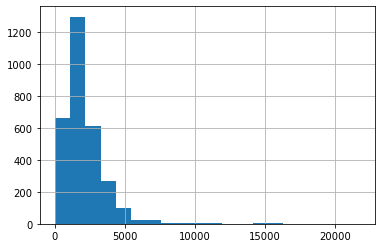

In [10]:
train_df_3['Length'].describe()
train_df_3['Length'].hist(bins=20)

In [11]:
train_df_4 = train_df_3[(train_df_3['Length'] > 1100) & (train_df_3['Length'] < 2500)]
train_df_4

,Original_Filename,Document,Middle,Section,Length
45,10050_533250_2,10050,533250,2,1316
76,10051_533283_2,10051,533283,2,1525
269,10070_533897_2,10070,533897,2,1183
379,1008_53463_2,1008,53463,2,1160
404,10120_538006_2,10120,538006,2,2258
...,...,...,...,...,...
63484,9808_519242_2,9808,519242,2,1404
63550,9811_884644_2,9811,884644,2,2301
63678,9923_528525_2,9923,528525,2,1658
63698,9936_529158_2,9936,529158,2,2385


array([[<AxesSubplot:title={'center':'Length'}>]], dtype=object)

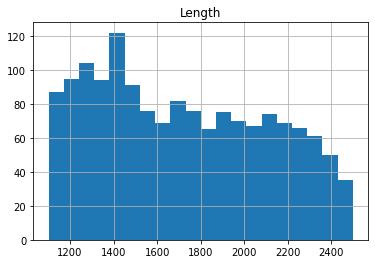

In [12]:
train_df_4.hist(bins=20)

<AxesSubplot:>

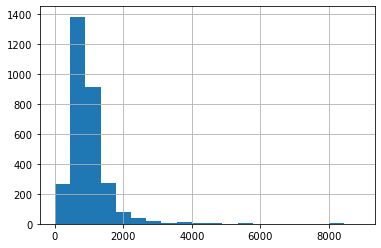

In [13]:
gs_df['Length'].hist(bins=20)

#### Merge the Training Metadata with Gold Standard Metadata

In [14]:
train_df_5 = train_df_4.merge(gs_df, how='left', on=['Document'])
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034
...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357


0        755
1        734
2       1202
3        864
4       1034
        ... 
1523     767
1524     501
1525     674
1526    1357
1527     518
Name: Length_y, Length: 1528, dtype: int64

<AxesSubplot:>

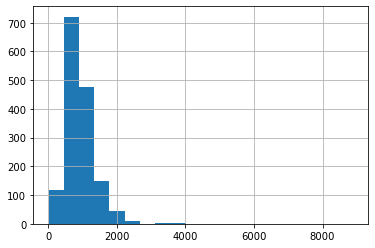

In [15]:
train_df_5['Length_y']
train_df_5['Length_y'].hist(bins=20)

Train_df_5 is the data containing the file names that will be used for appending summaries together.

### Appending the Data

In [16]:
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034
...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357


In [22]:
os.getcwd()

'D:\\Datasets\\453_NLP_Final_Project\\financial_documents\\training\\training_sections'

In [21]:
train_df_5.rename(columns={'Original_Filename_y':'Gold_Filename',
                   'Section_y':'Gold_Section',
                   'Length_y':'Gold_Summary_Length'}, inplace=True)
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold_Section,Gold_Summary_Length
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034
...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357


In [24]:
training_file_list = [x + str(".txt") for x in train_df_5['Original_Filename_x'].tolist()]
training_file_list

['10050_533250_2.txt',
 '10051_533283_2.txt',
 '10070_533897_2.txt',
 '1008_53463_2.txt',
 '10120_538006_2.txt',
 '10121_538026_2.txt',
 '1013_54134_2.txt',
 '1014_54148_2.txt',
 '1015_54162_2.txt',
 '1016_54175_2.txt',
 '10196_541224_2.txt',
 '10199_541305_2.txt',
 '102_4107_2.txt',
 '10225_542382_2.txt',
 '10226_542398_2.txt',
 '10227_542417_2.txt',
 '1023_54324_2.txt',
 '1027_54430_2.txt',
 '10368_548564_2.txt',
 '10382_548873_2.txt',
 '10385_549288_2.txt',
 '10386_549308_2.txt',
 '10387_549328_2.txt',
 '10390_549446_2.txt',
 '10391_549469_2.txt',
 '10419_597685_2.txt',
 '1044_54840_2.txt',
 '1045_54858_2.txt',
 '1046_54875_2.txt',
 '105_4169_2.txt',
 '10500_555515_2.txt',
 '10501_555534_2.txt',
 '10502_555556_2.txt',
 '10503_555576_2.txt',
 '10504_555599_2.txt',
 '10505_555627_2.txt',
 '10533_557557_2.txt',
 '10542_696162_2.txt',
 '10543_696180_2.txt',
 '10544_696200_2.txt',
 '10545_696222_2.txt',
 '10546_696243_2.txt',
 '10547_696266_2.txt',
 '10549_696319_2.txt',
 '10550_696346_2

In [27]:
training_data = []
for path in training_file_list:
    file = open(path, encoding='utf8')
    text = file.read()
    training_data.append(text)
    file.close()
for i in range(0, len(training_data)):
    training_data[i] = training_data[i].replace('\n', '')

In [31]:
# Save the Train_data_5 dataset for future usage
train_df_5.to_csv("D:/Datasets/453_NLP_Final_Project/Training_Data_Metadata.csv")

In [32]:
train_df_5['Full_Text'] = training_data
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold_Section,Gold_Summary_Length,Full_Text
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734,“”6 MEGGITT PLC REPORT AND ACCOUNTS ...
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202,Chief Executive’s reviewDivestments during th...
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864,STRATEGIC REPORT Chief Executive Officer’s st...
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034,CHIEF EXECUTIVE’S REVIEW6 Metalrax Group PLC ...
...,...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767,Marshalls plc Annual Report 2013 10Chief ...
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501,6 W&DB Annual Report 2003CHIEF EXECUTIVE’S RE...
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674,Strategic ReportChief executive’s reviewDeliv...
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357,06 / Mears Group PLC / Annual report and acco...


In [33]:
train_df_5["Length_Full_Text"] = train_df_5['Full_Text'].str.split().str.len()
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold_Section,Gold_Summary_Length,Full_Text,Length_Full_Text
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...,1296
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734,“”6 MEGGITT PLC REPORT AND ACCOUNTS ...,1503
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202,Chief Executive’s reviewDivestments during th...,1135
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864,STRATEGIC REPORT Chief Executive Officer’s st...,1133
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034,CHIEF EXECUTIVE’S REVIEW6 Metalrax Group PLC ...,1953
...,...,...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767,Marshalls plc Annual Report 2013 10Chief ...,1298
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501,6 W&DB Annual Report 2003CHIEF EXECUTIVE’S RE...,1957
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674,Strategic ReportChief executive’s reviewDeliv...,1599
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357,06 / Mears Group PLC / Annual report and acco...,2315


In [43]:
summary_file_list = [x + str(".txt") for x in train_df_5['Gold_Filename'].tolist()]
length_list = train_df_5['Length_Full_Text'].tolist()

In [45]:
os.chdir("D:/Datasets/453_NLP_Final_Project/financial_documents/training/training_gold_standards")
summary_data = []
for i in range(0, len(summary_file_list)):
    file = open(summary_file_list[i], encoding='utf8')
    text = file.read()
    # Each summary is the first 10% of the text, to keep comparisons even.
    summary_data.append(' '.join(text.split()[0:int(0.1*length_list[i])]))
    file.close()
for i in range(0, len(summary_data)):
    summary_data[i] = summary_data[i].replace('\n', '')

In [49]:
summary_data[0]
len(summary_data[0].split())

'3 Chairman’s statement Oxford University’s Said Business School. The Meggitt Production System, the Group’s wide-ranging continuous improvement initiative, embodies a faculty of operational excellence for the large number of employees touched by it. As a leading employer of engineers and manufacturing experts, we are naturally committed to maintaining the industry pipeline of expertise. This will undoubtedly be stimulated by the opportunities arising from the UK government’s commitment to co-funding investment in the aerospace and defence industry. As a business we are picking up the baton, developing young talent, sponsoring students with engineering aspirations through the Arkwright Scholarship Trust. In turn, they are benefiting from mentoring by engineering graduates from our own highly successful international graduate development programme in which we take care to engage bright minds early in very'

129

In [50]:
train_df_5['Summary_Text'] = summary_data
train_df_5

,Original_Filename_x,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold_Section,Gold_Summary_Length,Full_Text,Length_Full_Text,Summary_Text
0,10050_533250_2,10050,533250,2,1316,10050_533249_1,533249,1,755,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...,1296,3 Chairman’s statement Oxford University’s Sai...
1,10051_533283_2,10051,533283,2,1525,10051_533282_1,533282,1,734,“”6 MEGGITT PLC REPORT AND ACCOUNTS ...,1503,Chairman’s statement Growing the Group It’s be...
2,10070_533897_2,10070,533897,2,1183,10070_533896_1,533896,1,1202,Chief Executive’s reviewDivestments during th...,1135,Chairman’s statement I am pleased to report ou...
3,1008_53463_2,1008,53463,2,1160,1008_53459_1,53459,1,864,STRATEGIC REPORT Chief Executive Officer’s st...,1133,GROUP OVERVIEW Chairman’s statement 2014 has b...
4,10120_538006_2,10120,538006,2,2258,10120_538005_1,538005,1,1034,CHIEF EXECUTIVE’S REVIEW6 Metalrax Group PLC ...,1953,2 Metalrax Group PLC Engineering specialists I...
...,...,...,...,...,...,...,...,...,...,...,...,...
1523,9808_519242_2,9808,519242,2,1404,9808_519241_1,519241,1,767,Marshalls plc Annual Report 2013 10Chief ...,1298,Marshalls plc Annual Report 2013 8 Chairman’s ...
1524,9811_884644_2,9811,884644,2,2301,9811_884643_1,884643,1,501,6 W&DB Annual Report 2003CHIEF EXECUTIVE’S RE...,1957,4 W&DB Annual Report 2003 CHAIRMAN’S STATEMENT...
1525,9923_528525_2,9923,528525,2,1658,9923_528523_1,528523,1,674,Strategic ReportChief executive’s reviewDeliv...,1599,Strategic Report Chairman’s statement Proud to...
1526,9936_529158_2,9936,529158,2,2385,9936_529157_1,529157,1,1357,06 / Mears Group PLC / Annual report and acco...,2315,02 / Mears Group PLC / Annual report and accou...


In [53]:
train_df_5.set_index(['Original_Filename_x', 'Gold_Filename'], inplace=True)
train_df_6 = train_df_5[['Document', 'Full_Text', 'Summary_Text']]

In [54]:
train_df_6

,,Document,Full_Text,Summary_Text
Original_Filename_x,Gold_Filename,,,
10050_533250_2,10050_533249_1,10050,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...,3 Chairman’s statement Oxford University’s Sai...
10051_533283_2,10051_533282_1,10051,“”6 MEGGITT PLC REPORT AND ACCOUNTS ...,Chairman’s statement Growing the Group It’s be...
10070_533897_2,10070_533896_1,10070,Chief Executive’s reviewDivestments during th...,Chairman’s statement I am pleased to report ou...
1008_53463_2,1008_53459_1,1008,STRATEGIC REPORT Chief Executive Officer’s st...,GROUP OVERVIEW Chairman’s statement 2014 has b...
10120_538006_2,10120_538005_1,10120,CHIEF EXECUTIVE’S REVIEW6 Metalrax Group PLC ...,2 Metalrax Group PLC Engineering specialists I...
...,...,...,...,...
9808_519242_2,9808_519241_1,9808,Marshalls plc Annual Report 2013 10Chief ...,Marshalls plc Annual Report 2013 8 Chairman’s ...
9811_884644_2,9811_884643_1,9811,6 W&DB Annual Report 2003CHIEF EXECUTIVE’S RE...,4 W&DB Annual Report 2003 CHAIRMAN’S STATEMENT...
9923_528525_2,9923_528523_1,9923,Strategic ReportChief executive’s reviewDeliv...,Strategic Report Chairman’s statement Proud to...


In [55]:
train_df_6.to_csv("D:/Datasets/453_NLP_Final_Project/Training_Data.csv")

In [ ]:
# Load the Data for Cleaning

In [2]:
train_data = pd.read_csv("D:/Datasets/453_NLP_Final_Project/Training_Data.csv")
train_data.head(10)

,Original_Filename_x,Gold_Filename,Document,Full_Text,Summary_Text
0,10050_533250_2,10050_533249_1,10050,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...,3 Chairman’s statement Oxford University’s Sai...
1,10051_533283_2,10051_533282_1,10051,“”6 MEGGITT PLC REPORT AND ACCOUNTS ...,Chairman’s statement Growing the Group It’s be...
2,10070_533897_2,10070_533896_1,10070,Chief Executive’s reviewDivestments during th...,Chairman’s statement I am pleased to report ou...
3,1008_53463_2,1008_53459_1,1008,STRATEGIC REPORT Chief Executive Officer’s st...,GROUP OVERVIEW Chairman’s statement 2014 has b...
4,10120_538006_2,10120_538005_1,10120,CHIEF EXECUTIVE’S REVIEW6 Metalrax Group PLC ...,2 Metalrax Group PLC Engineering specialists I...
5,10121_538026_2,10121_538025_1,10121,Annual Report 2006 Metalrax Group PLC 413240 ...,Annual Report 2006 Metalrax Group PLC 2 Chairm...
6,1013_54134_2,1013_54133_1,1013,Annual Report 20110420660-04 03/10/2011 Proof...,Annual Report 2011 02 20660-04 03/10/2011 Proo...
7,1014_54148_2,1014_54147_1,1014,06Animalcare Group plcAnnual Report and Accou...,04 Animalcare Group plc Annual Report and Acco...
8,1015_54162_2,1015_54161_1,1015,22779.04 Proof 3 08-10-13Chief Executiv...,22779.04 Proof 3 08-10-13 Chairman’s Statement...
9,1016_54175_2,1016_54174_1,1016,Chief Executive’s ReviewIain Menneer Chief Ex...,Chairman’s Statement James Lambert Chairman In...


In [20]:
# Function to remove non-ascii characters from the text

def remove_non_ascii(text_list):
    clean_list = []
    for text in text_list:
        try:
            temp_encode = text.encode('ascii', 'ignore')
            temp_decode = temp_encode.decode('ascii')
        except:
            continue
        finally:
            clean_list.append(temp_decode)
    return clean_list

In [11]:
unclean_full_text = list(train_data['Full_Text'])
clean_full_text = remove_non_ascii(unclean_full_text)
clean_full_text[0]

' 4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Executives reviewWe have emerged from an intensive bid cycle resulting  in technology sales into a significant number of new aircraft programmes, many involve a full suite of Meggitt capabilities, exceeding the shipset content of their predecessors. This is a very strong indicator of future revenue growth. Group strategyIn my first Annual Report and Accounts since becoming Meggitts Chief Executive, I am delighted to reaffirm my commitment to the strategy I was integral in developing since joining the Group as Finance Director in 2004. Meggitts strategy comprises four elements. Delivering innovationWe focus on highly-engineered components and sub-systems capable  of withstanding increasingly harsh environments, such as in the next-generation aero-engines. Our products must operate in extremes of pressure, temperature, impact, vibration and contamination in applications where certification requirements are demanding. We invest in manufacturing

In [17]:
unclean_summary_text[0]

'3 Chairman’s statement Oxford University’s Said Business School. The Meggitt Production System, the Group’s wide-ranging continuous improvement initiative, embodies a faculty of operational excellence for the large number of employees touched by it. As a leading employer of engineers and manufacturing experts, we are naturally committed to maintaining the industry pipeline of expertise. This will undoubtedly be stimulated by the opportunities arising from the UK government’s commitment to co-funding investment in the aerospace and defence industry. As a business we are picking up the baton, developing young talent, sponsoring students with engineering aspirations through the Arkwright Scholarship Trust. In turn, they are benefiting from mentoring by engineering graduates from our own highly successful international graduate development programme in which we take care to engage bright minds early in very'

In [21]:
unclean_summary_text = list(train_data['Summary_Text'])
clean_summary_text = remove_non_ascii(unclean_summary_text)
clean_summary_text[0]

'3 Chairmans statement Oxford Universitys Said Business School. The Meggitt Production System, the Groups wide-ranging continuous improvement initiative, embodies a faculty of operational excellence for the large number of employees touched by it. As a leading employer of engineers and manufacturing experts, we are naturally committed to maintaining the industry pipeline of expertise. This will undoubtedly be stimulated by the opportunities arising from the UK governments commitment to co-funding investment in the aerospace and defence industry. As a business we are picking up the baton, developing young talent, sponsoring students with engineering aspirations through the Arkwright Scholarship Trust. In turn, they are benefiting from mentoring by engineering graduates from our own highly successful international graduate development programme in which we take care to engage bright minds early in very'

In [22]:
# Replace the columns with the clean data

train_data["Full_Text"] = clean_full_text
train_data["Summary_Text"] = clean_summary_text

In [26]:
train_data.rename(columns={'Full_Text': 'ctext', 'Summary_Text':'text'}, inplace=True)
train_data.head(10)

,Original_Filename_x,Gold_Filename,Document,ctext,text
0,10050_533250_2,10050_533249_1,10050,4MEGGITT PLC REPORT AND ACCOUNTS 2013Chief Ex...,3 Chairmans statement Oxford Universitys Said ...
1,10051_533283_2,10051_533282_1,10051,6 MEGGITT PLC REPORT AND ACCOUNTS 20...,Chairmans statement Growing the Group Its been...
2,10070_533897_2,10070_533896_1,10070,Chief Executives reviewDivestments during the...,Chairmans statement I am pleased to report our...
3,1008_53463_2,1008_53459_1,1008,STRATEGIC REPORT Chief Executive Officers sta...,GROUP OVERVIEW Chairmans statement 2014 has be...
4,10120_538006_2,10120_538005_1,10120,CHIEF EXECUTIVES REVIEW6 Metalrax Group PLC E...,2 Metalrax Group PLC Engineering specialists I...
5,10121_538026_2,10121_538025_1,10121,Annual Report 2006 Metalrax Group PLC 413240 ...,Annual Report 2006 Metalrax Group PLC 2 Chairm...
6,1013_54134_2,1013_54133_1,1013,Annual Report 20110420660-04 03/10/2011 Proof...,Annual Report 2011 02 20660-04 03/10/2011 Proo...
7,1014_54148_2,1014_54147_1,1014,06Animalcare Group plcAnnual Report and Accou...,04 Animalcare Group plc Annual Report and Acco...
8,1015_54162_2,1015_54161_1,1015,22779.04 Proof 3 08-10-13Chief Executiv...,22779.04 Proof 3 08-10-13 Chairmans Statement ...
9,1016_54175_2,1016_54174_1,1016,Chief Executives ReviewIain Menneer Chief Exe...,Chairmans Statement James Lambert Chairman Int...


In [27]:
train_data.to_csv("D:/Datasets/453_NLP_Final_Project/Training_Data_Clean.csv")